Created by Michael Doxey, Pranav Khatri, and Harsh Patel :)

# Introduction

It is no secret that many students from ages 15-22 enjoying drinking alcohol (often underage), but is this a cause for concern academically? Using a dataset that contains information about students' (ages 15-22) alcohol consumption, social lives, and academic success, this tutorial will attempt to find out if student alcohol consumption habits factor into their academic success.

In determining this, this tutorial will cover a wide range of data science topics will be covered, including importing and cleaning a dataset, analyzing and interpreting the data via exploratory data analysis using several Python libraries, hypothesis testing and machine learning.

# Getting Started

Before we start, we must make the appropriate imports of the Python libraries we will use. To store the data in DataFrames (tables), we will use Pandas. For exploratory data analysis, we will use Seaborn and matplotlib. Lastly, for additional Python computing and analysis, we will use SciPy and NumPy. Finally, for the machine learning, we will use sklearn.

To install these libraries, make sure you have [Anaconda](https://conda.io/docs/user-guide/install/index.html) or [pip](https://pip.pypa.io/en/stable/installing/) installed. Then, run the command:

```conda install <package>``` 

or 

```pip install <package>``` 

depending on which package management system you have set up.

For more information or documentation for any of these libraries, look at the last section for further resources.

In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz
from scipy import stats
from sklearn import tree
from sklearn.model_selection import train_test_split
sns.set_context({"figure.figsize": (24, 10)})

## Data Collection

In order to analyze the data on student alcohol consumption, we must first load in the datasets available on Kaggle (INSERT LINK HERE). The two datasets consist of surveys from math and Portuguese courses in two secondary schools and are separated into two separate files.

Using Pandas, I load each survey's csv file into their respective DataFrame.

In [40]:
stud_math = pd.read_csv('student_alc.csv')
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [41]:
stud_port = pd.read_csv('student_port.csv')
stud_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Entity Resolution

Next, another important part in the data collection and cleaning process is Entity Resolution. According to UCI Machine Learning, who posted the dataset on Kaggle, there are nearly 400 students that are in both the math and Portuguese class, and thus show up in both surveys. Although tempting to just append the datasets together, this will skew the data since some students will show up twice.

To resolve this, we must use the information in the survey to match students who are in both classes. First, we add a StudentID column to the math class' DataFrame to serve as a primary key (and eventually foreign key for the Portuguese class'), by assigning each student a unique number.

In [42]:
numrows = stud_math.shape[0]
ids = range(1, numrows+1)
stud_math['StudentID'] = pd.Series(ids)
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,StudentID
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,5


Next, we must use the Portuguese class DataFrame to match StudentID's from the math class. Using only information that would not have fluctuated for a student based on the course (such as school, gender, address, guardian information), we can query the math class to identify the same students in the Portuguese dataset. If/when a match is found, we assign the row the same StudentID. If a match is not found, a new and unique StudentID is assigned to the row.

In [43]:
newID = 396
stud_port['StudentID'] = np.nan
stud_port.head()
for i, row in stud_port.iterrows():
    mathRow = stud_math[(stud_math.school == row.school) & (stud_math.sex == row.sex) & \
                        (stud_math.age == row.age) & (stud_math.address == row.address) &\
                        (stud_math.famsize == row.famsize) & (stud_math.Pstatus == row.Pstatus) &\
                        (stud_math.Medu == row.Medu) & (stud_math.Fedu == row.Fedu) &\
                        (stud_math.Mjob == row.Mjob) & (stud_math.Fjob == row.Fjob) &\
                        (stud_math.reason == row.reason) & (stud_math.nursery == row.nursery) &\
                        (stud_math.internet == row.internet) & (stud_math.higher == row.higher) &\
                        (stud_math.romantic == row.romantic) & (stud_math.activities == row.activities) &\
                        (stud_math.guardian == row.guardian) & (stud_math.traveltime == row.traveltime)]
    if len(mathRow) == 1:
        stud_port.set_value(i, 'StudentID', mathRow.iloc[0]['StudentID'])
    else:
        stud_port.set_value(i, 'StudentID', newID)
        newID += 1
stud_port.StudentID = stud_port.StudentID.astype(int)
stud_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,StudentID
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,5


After identifying the same students in both courses, we can drop the columns we do not need in both DataFrames.

In [44]:
#deleted rows that are not needed

del stud_math['reason']
del stud_math['guardian']
del stud_math['schoolsup']
del stud_math['famsup']
del stud_math['nursery']

del stud_port['reason']
del stud_port['guardian']
del stud_port['schoolsup']
del stud_port['famsup']
del stud_port['nursery']

# Exploratory Data Analysis

Now that we have all of our datasets imported into DataFrames, we can start to analyze the data to find any trends. One of the easiest and most visual ways to view the data is through exploratory data analysis, where we can plot the data using Seaborn and matplotlib to see if we can observe any obvious trends.

Based on the survey, there are several different factors of a student's life that we can explore to see if alcohol consumption is affected most by:

- Demographic information (How does a student's gender affect their alcohol consumption habits?)

- Home life (How do family relationships affect student alcohol consumption habits?)

- Academic performance (Is it true that students who drink more perform worse in class?)

### Student Demographics

Since our main goal is to find the potential main factors causing or correlated with student alcohol consumption, we should first observe student alcohol habits as a whole. We can do this by creating a histogram using the 'Walc' column in the DataFrame, which is an ordinal scale from 1-5, with 5 indicating very high weekend alcohol consumption.

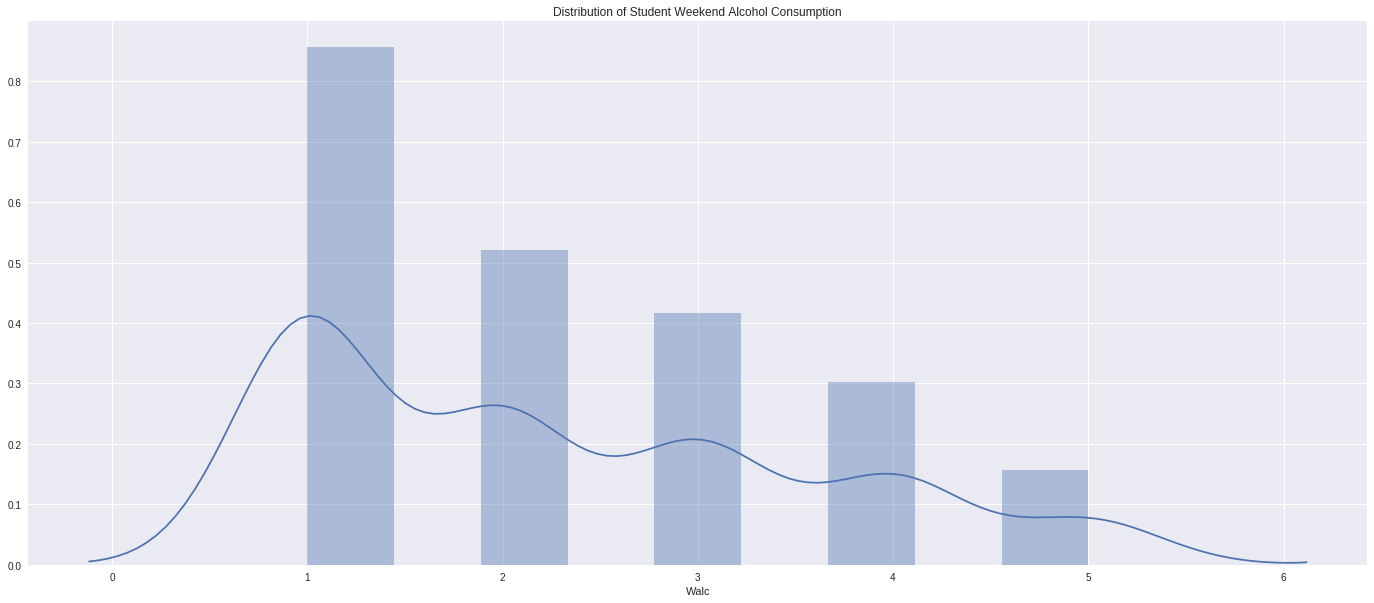

In [45]:
sns.distplot(stud_port['Walc'])
plt.title('Distribution of Student Weekend Alcohol Consumption')
plt.show()

We can clearly see that although it seems the plurality of students have "very low" weekend alcohol consumption, many (if not most) students have indicated they consume alcohol on the weekends. Nevertheless, we observe a right-skew here, meaning that these scores fall towards the lower side of the scale.

One of the simplest ways to separate the data is by sex. Do males tend to have higher alcohol consumption habits than females? To see if there is a trend here, we can create a grouped bar chart, where each score is separated by the number of students who selected that score by sex.

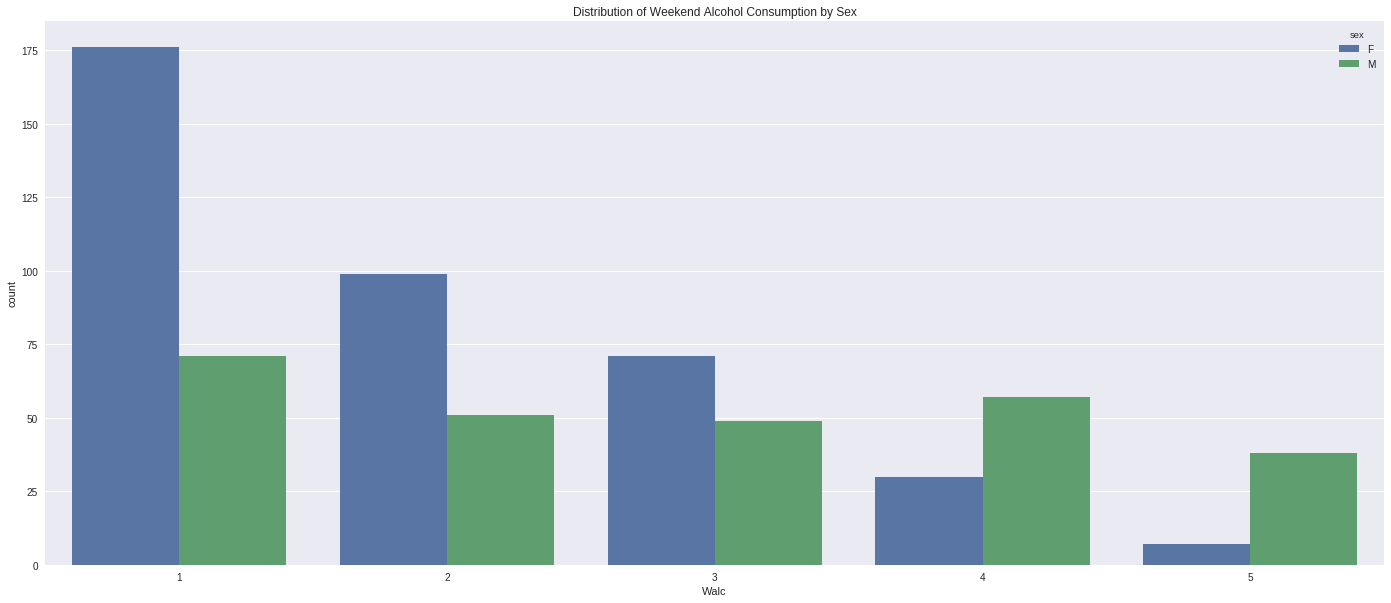

In [46]:
sns.countplot(x="Walc", hue="sex", data=stud_port)
plt.title('Distribution of Weekend Alcohol Consumption by Sex')
plt.show()

In this bar chart, we can clearly see that a higher proportion of males have indicated higher weekend drinking habits than females. While the female distribution is very skewed to the right, the distribution for males seems to be more bimodal, with peaks at Walc=1 and Walc=4. This means that that there are a high proportion of males in this survey that do have moderate to high drinking habits on the weekends.

Another factor that may predict student alcohol consumption habits is their age. We can create a bar chart that displays the average Walc score for each age of students represented in the survey.

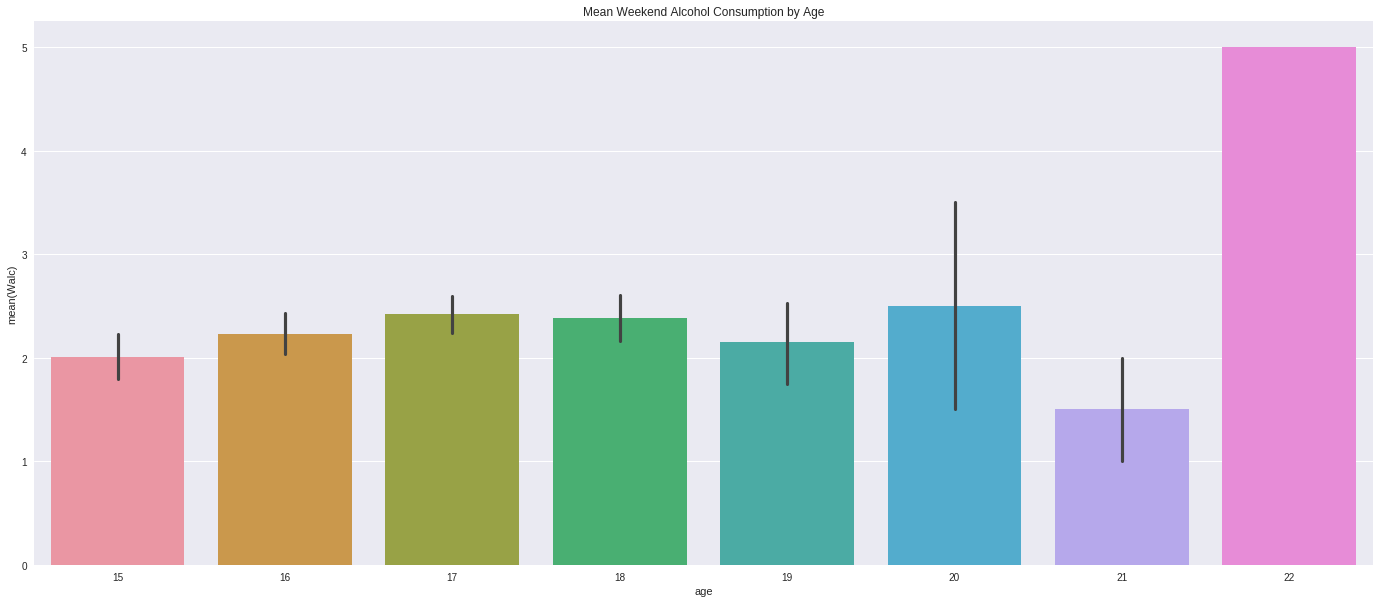

In [47]:
sns.barplot(x="age", y="Walc", data=stud_port)
plt.title('Mean Weekend Alcohol Consumption by Age')
plt.show()

While there seems to be no definitive trend of consumption by age, the one thing that does jump out is the average Walc score of 5 for students 22 years old. However, this is slightly misleading, as there is most likely only one or two students who are 22, which skews the average. Disregarding the spike at 22 years old, however, the rest of the distribution looks to be fairly consistent, with slight bimodal peaks at 20 and 17.

### Student Home Life

Next, we may be tempted to see how a student's home and family life affects their alcohol habits.

Again, using Seaborn, we can create a barplot seeing how a student's relationship with his/her family affects alcohol consumption habits. We may expect that a student with a worse family relationship has high alcohol consumption habits, whereas students with stronger family relationships have lower alcohol consumption habits.

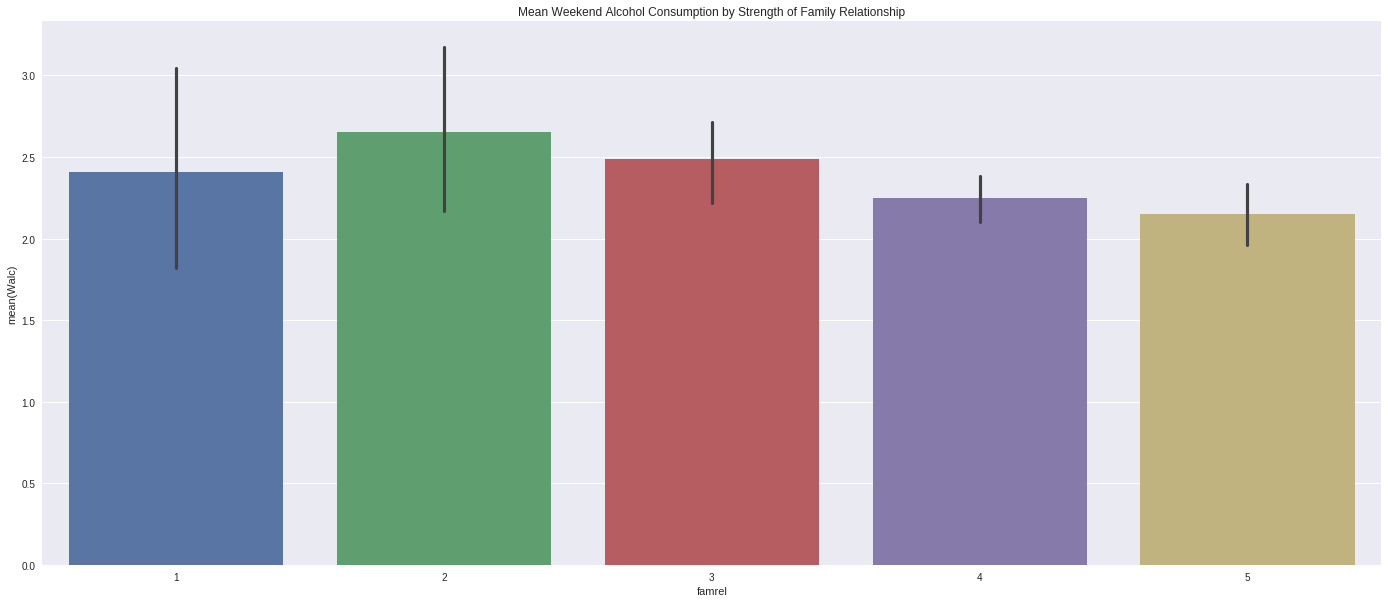

In [48]:
sns.barplot(x="famrel", y="Walc", data=stud_port)
plt.title('Mean Weekend Alcohol Consumption by Strength of Family Relationship')
plt.show()

Although there is not the highest average alcohol consumption habits with the worst family relationship option, we do see a peak at famrel = 2. From there, we see a decreasing trend of student alcohol consumption habits. This unimodal, right-skewed distribution confirms our inhibition that there does seem to be a negative correlation between student alcohol habits and strength of family relationships.

Going along the same thought process, we can next plot a bar chart of student alcohol habits by whether or not a student's parents live together or apart.

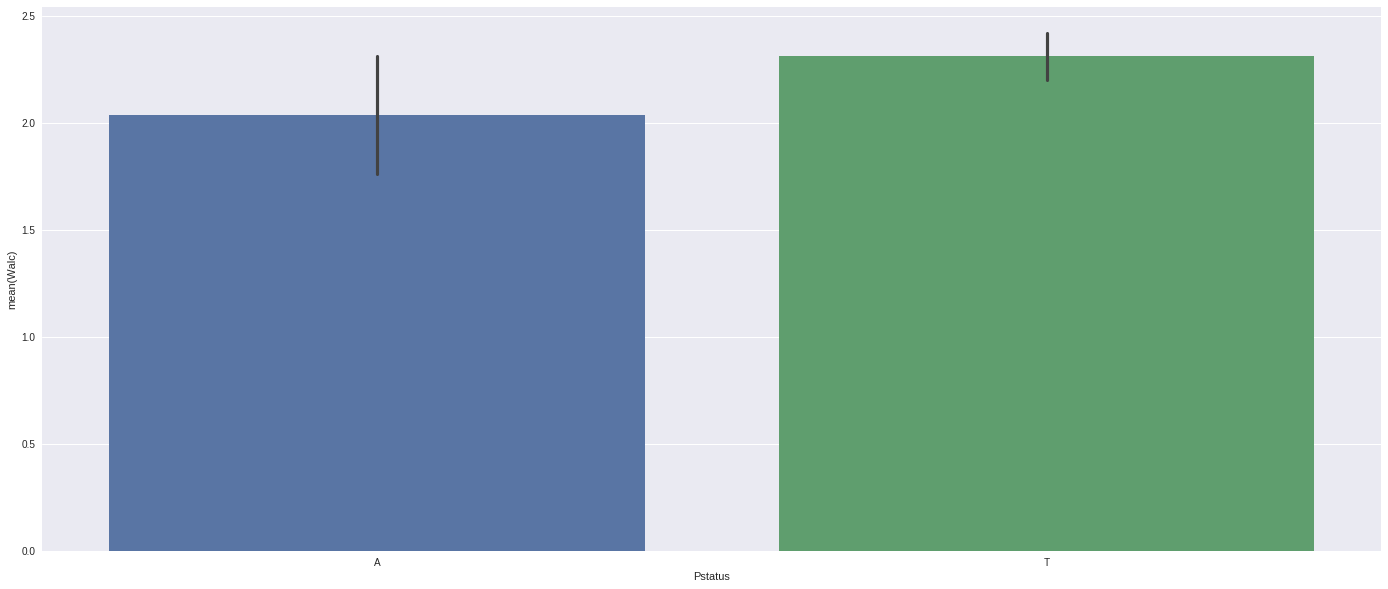

In [49]:
sns.barplot(x="Pstatus", y="Walc", data=stud_port)
plt.show()

Based on the bar plot above, we see that students with parents that live together (T) tend to have slightly higher alcohol consumption habits on the weekend than that of students with parents that live apart (A).

### Student Academic Performance

Do students who perform worse in school tend to have higher alcohol consumption? Unlike the other two factors we observed above (demographic and home life), academic performance is something that can actually be controlled. As a result, it would seem that we are more likely to observe trends here, as alcohol performance may serve as a predictor for how students perform in school.

Before we see how alcohol related factors tend to skew grades, let's take a look at the grade distributions themselves for both classes: Portuguese and math.

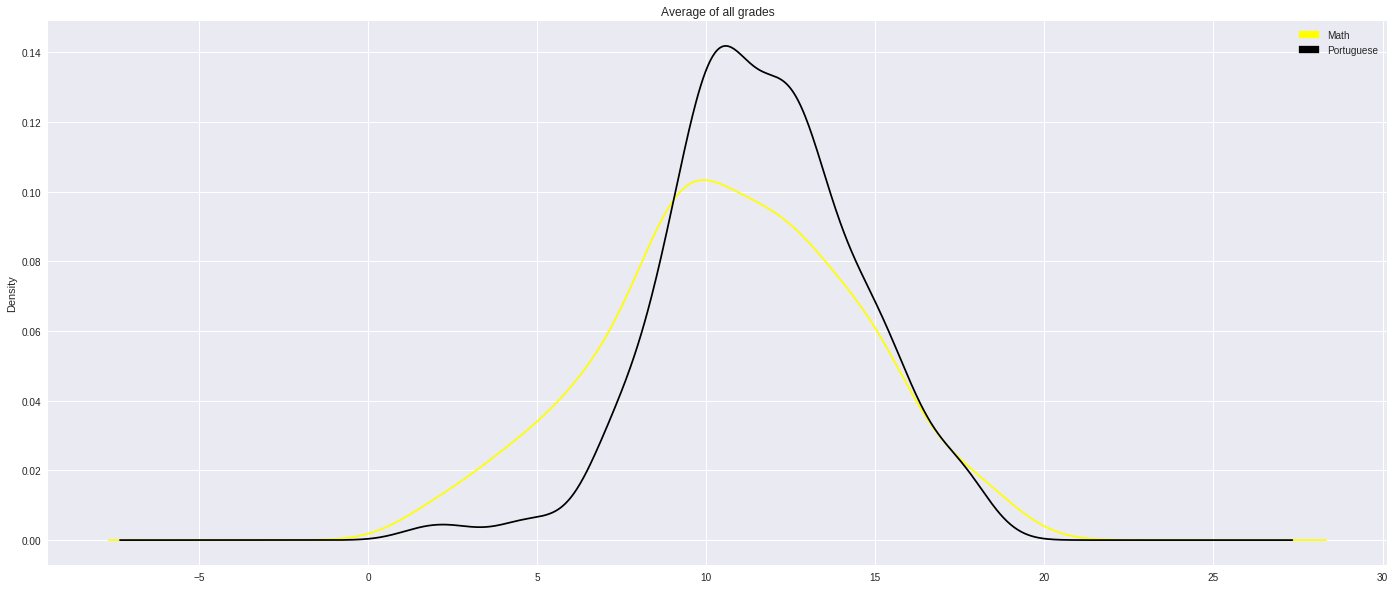

In [50]:
# function for getting average grade over all 3 grade periods (G1, G2, G3)
def avg_grade(stud):
    x = (stud['G1']+stud['G2']+stud['G3'])/3 
    return x
# import for generating legend
import matplotlib.patches as mpatches
# get grade averages for all students
stud_math['avg'] = stud_math.apply(lambda row: avg_grade(row), axis = 1)
stud_port['avg'] = stud_port.apply(lambda row: avg_grade(row), axis = 1)
# plot averages as density plot for both classes
stud_math['avg'].plot(kind = "density", color = 'yellow')
stud_port['avg'].plot(kind = "density", title = 'Average of all grades', color = 'black')
# generate legend
math = mpatches.Patch(color='yellow', label='Math')
port = mpatches.Patch(color='black', label='Portuguese')
plt.legend(handles=[math, port])
plt.show()

Looking at the density plot showing grade average distributions, we can clearly see that students tend to perform better in the Portuguese course than in the math course. We see a higher peak and more right-skew for the Portuguese distribution, while we we a lower peak for the math course.

To observe a distribution of academic performance by student alcohol consumption habits, we can create a violin plot. The below chart shows the distribution of final (G3) grades in the Portuguese class for each 'Walc' score (alcohol consumption habits on the weekend).

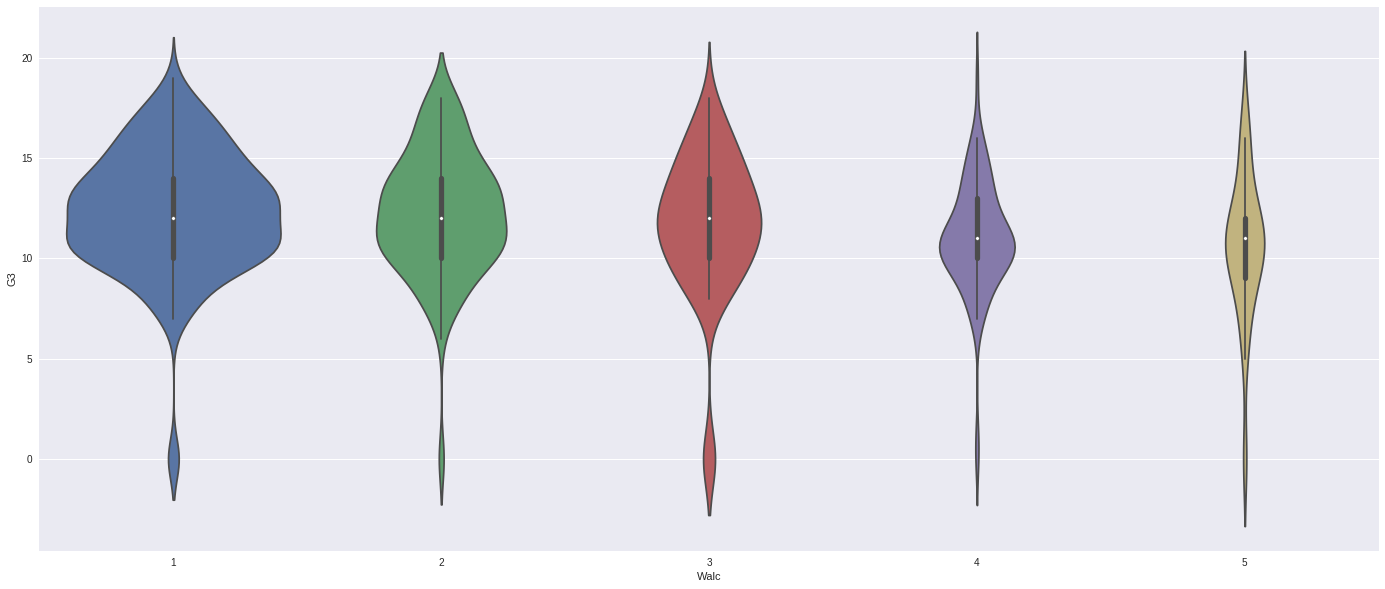

In [51]:
sns.violinplot(x='Walc', y='G3', data=stud_port, scale='count')
plt.show()

Perhaps unsurprisingly, we can note a downwards trend in grades for higher alcohol consumption habits. For low alcohol consumption rates, with Walc=1 or Walc=2, the grade distributions tend to skew towards higher grades (where 20 is the max grade score).

Because of the noted difference of male and female alcohol consumption habits above, we would next like to see the grade distribution grouped by sex and weekend alcohol consumption habit score.

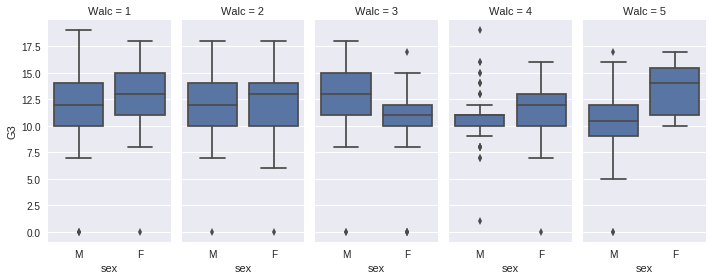

In [52]:
#box whisker for sex vs walc and grades
g = sns.FacetGrid(stud_port, col='Walc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'sex', 'G3')
# sns.plt.show()
plt.show()

Similarly to the violin plot above, we see that for the most part, students who drink more on the weekends do worse academically. However, we do see some discrepency for this trend, like the higher performing females who have Walc=5. In addition, besides Walc=3, we noted that females tend to have higher G3 scores than males.

Lastly, we can generate a scatterplot to see if there's any strong correlations between grades and any other social factors, such as alcohol consumption or going out habits.

In [53]:
def getScatterPlotByColumn(colname):
    fig, ax = plt.subplots()
    # generate scatterplot between column and final grades (y)
    ax.scatter(stud_port[colname], stud_port['G3'])
    # calculate and plot regression line for relationship between the two variables
    m, y = np.polyfit(stud_port[colname], stud_port['G3'], 1)
    plt.plot(stud_port[colname], m * stud_port[colname] + y, '-',color="magenta")
    plt.title('G3 vs {} '.format(colname))
    plt.xlabel(colname)
    plt.ylabel('G3')
    plt.show()
    # print out r^2 value for relationship between the two variables
    slope, intercept, r_value, p_value, std_err = stats.linregress(stud_port[colname], stud_port['G3'])
    print('r^2 value for correlation between {} and G3: {}'.format(colname, r_value**2))

Below, we see a scatter plot between the amount students go out with friends (5 being the highest) and how they perform in school.

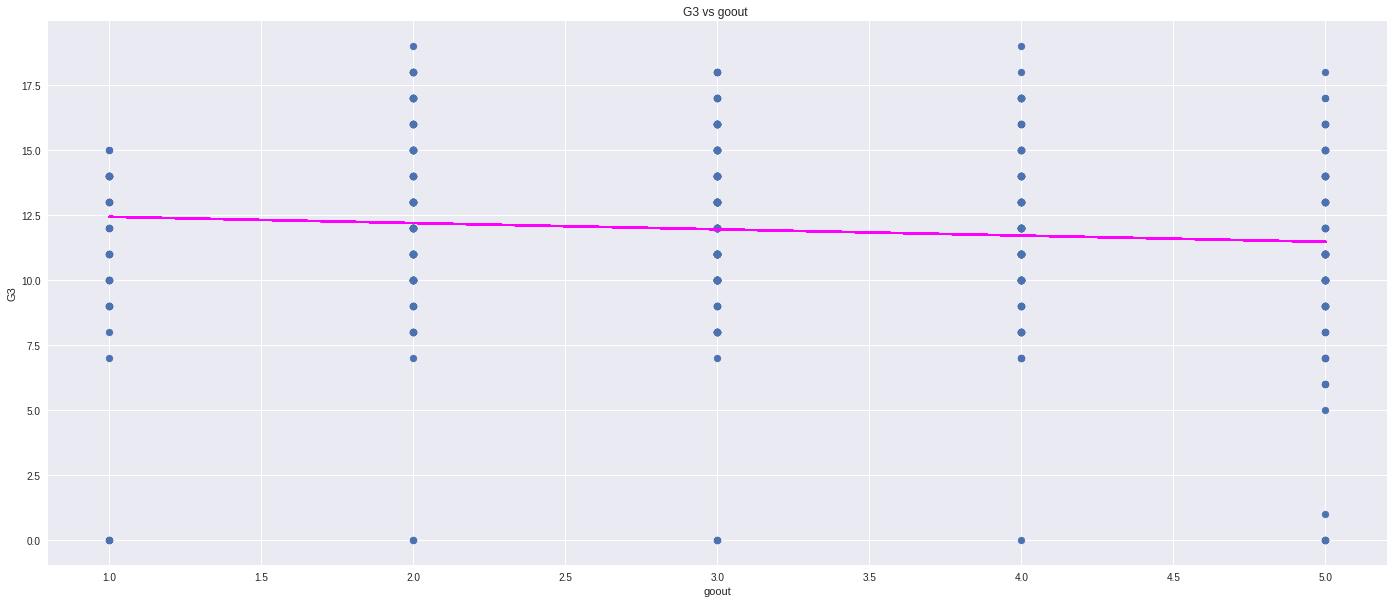

r^2 value for correlation between goout and G3: 0.007680896279627491


In [54]:
getScatterPlotByColumn('goout')

As we may expect, we see a weak negative correlation between the amount students go out and how they perform in school.

Again, we show a scatterplot, this time showing the relationship between the amount students study (5 being the highest) and their final grades.

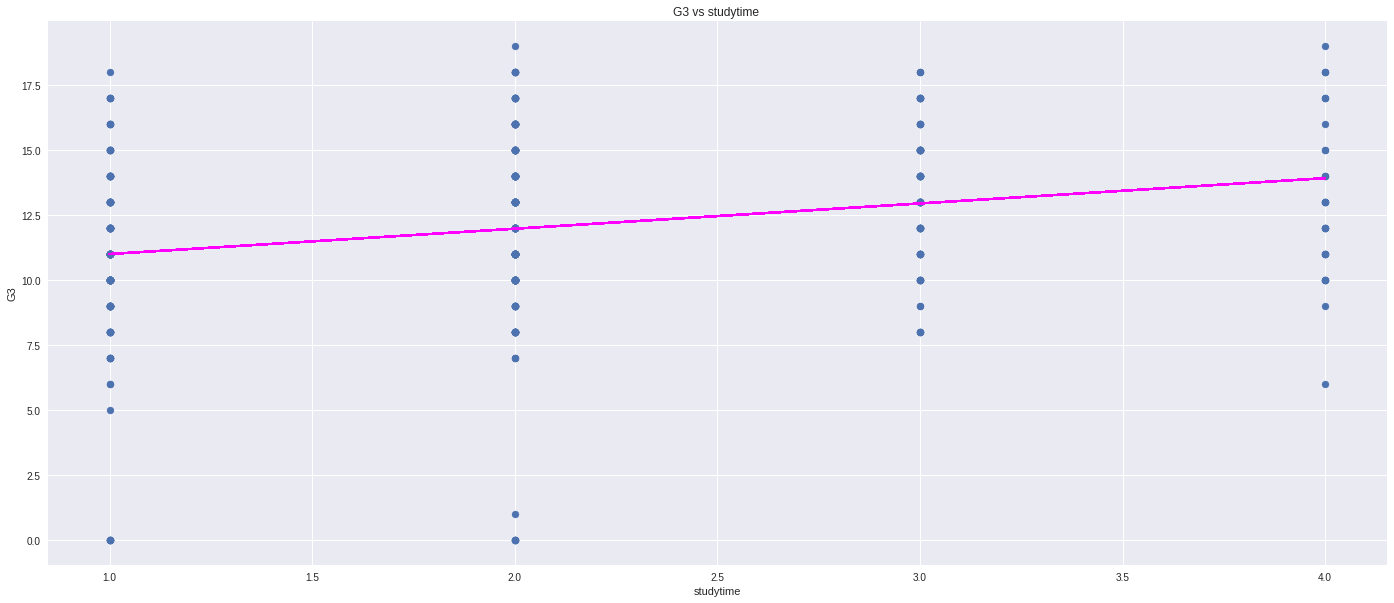

r^2 value for correlation between studytime and G3: 0.06239438965134818


In [55]:
#study time vs grades
getScatterPlotByColumn('studytime')

Unsurprisingly, we see a slightly stronger positive correlation between the amount students study and their final grades.

To sum up our exploratory data analysis, we create two correlation heat maps that shows the correlation between all variables in both courses.

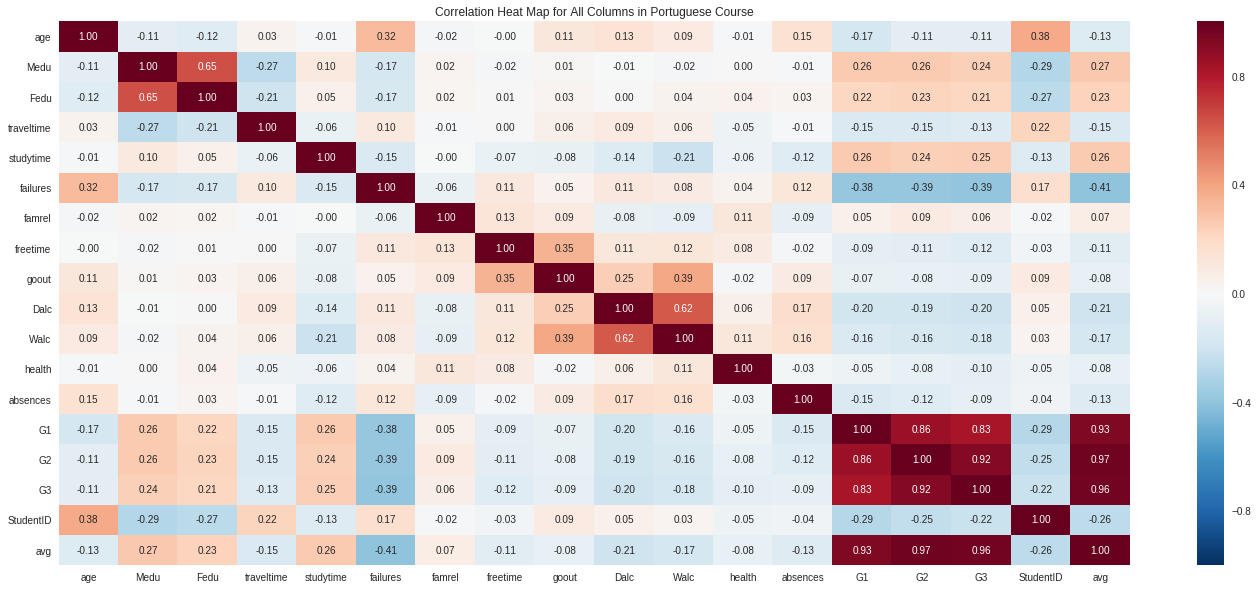

In [56]:
plt.title('Correlation Heat Map for All Columns in Portuguese Course')
sns.heatmap(stud_port.corr(),annot = True,fmt = ".2f",cbar = True)
plt.show()

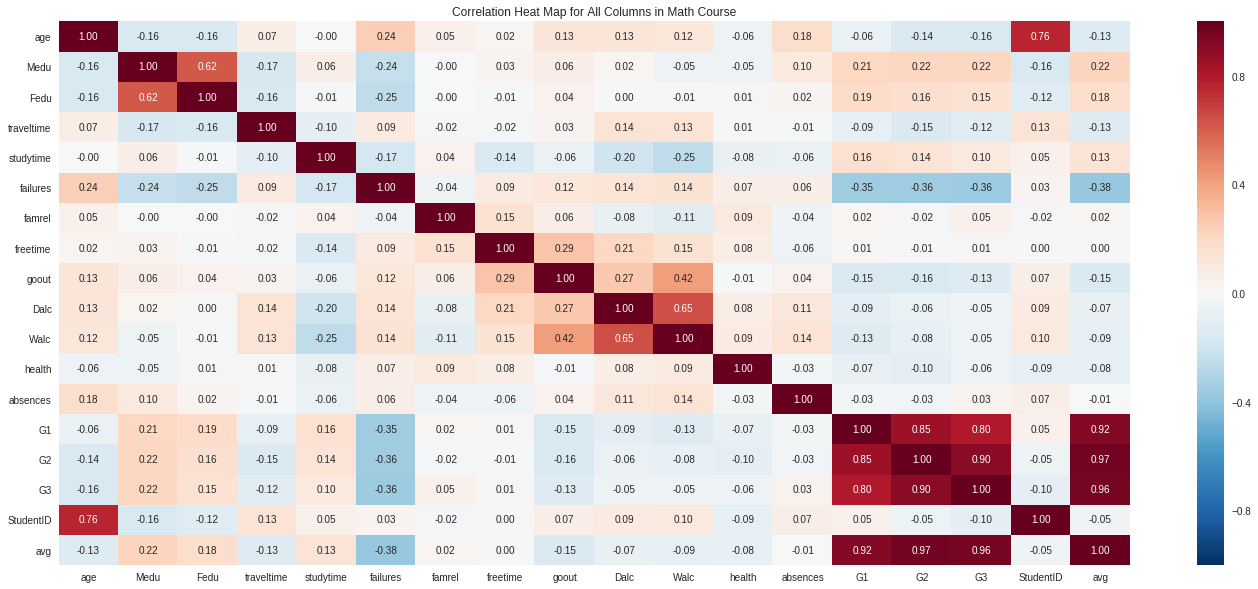

In [57]:
plt.title('Correlation Heat Map for All Columns in Math Course')
sns.heatmap(stud_math.corr(),annot = True,fmt = ".2f",cbar = True)
plt.show()

Disregarding some of the irrelevant columns (like StudentID), we can find some interesting trends that we may not have caught before. These heat maps show some interesting trends that confirm some of our inhibitions: failures negatively correlating with average grades, alcohol consumption habits with going out habits, and failures correlating with parent's education. 

# Machine Learning

## Installation Prerequisites

This tutorial requires installation of graphviz.
To install graphviz follow these instructions https://graphviz.gitlab.io/download/

## Data Collection and Preparation

Here we will reread the csv into the a dataframe to get a full version of the data that we can prepare for use in a machine learning classifier. We will add another column labeled 'Pass'. This column will either have True/False depending on if the students final grade is above a D.

In [58]:
stud_alc = pd.read_csv('student_alc.csv')
stud_alc['Pass'] = pd.Series('', index=stud_alc.index)

Here we prepare the data for classification. Classifiers can only use data that has integers, doubles, or booleans. For this reason we convert all strings in the table to a categorical integer or boolean value. If you are doing classification with many categorical string values then languages like R are much more accomodating of this. You should take a look at classification in R if this is something you are interested in as it makes data preparation much simpler.

In [59]:
job = {'at_home':0, 'health':1, 'other':2, 'services':3, 'teacher':4}
reason = {'course':0, 'home':1, 'other':2, 'reputation':3}
guardian = {'father':0, 'mother':1, 'other':2}
for index, row in stud_alc.iterrows():
    if row["school"] == "GP":
        stud_alc.set_value(index,'school',False)
    else:
        stud_alc.set_value(index,'school',True)
    if row["sex"] == "F":
        stud_alc.set_value(index,'sex',False)
    else:
        stud_alc.set_value(index,'sex',True)
    if row["address"] == "U":
        stud_alc.set_value(index,'address',False)
    else:
        stud_alc.set_value(index,'address',True)
    if row["famsize"] == "GT3":
        stud_alc.set_value(index,'famsize',True)
    else:
        stud_alc.set_value(index,'famsize',False)
    if row["Pstatus"] == "A":
        stud_alc.set_value(index,'Pstatus',False)
    else:
        stud_alc.set_value(index,'Pstatus',True)
        
    stud_alc.set_value(index,'Mjob',job[row["Mjob"]])
    stud_alc.set_value(index,'Fjob',job[row["Fjob"]])
    stud_alc.set_value(index,'reason',reason[row["reason"]])
    stud_alc.set_value(index,'guardian',guardian[row["guardian"]])
    
    # categorizing schoolsup
    if row["schoolsup"] == "yes":
        stud_alc.set_value(index,'schoolsup',True)
    else:
        stud_alc.set_value(index,'schoolsup',False)
    # categorizing internet
    if row["famsup"] == "yes":
        stud_alc.set_value(index,'famsup',True)
    else:
        stud_alc.set_value(index,'famsup',False)
    # categorizing paid
    if row["paid"] == "yes":
        stud_alc.set_value(index,'paid',True)
    else:
        stud_alc.set_value(index,'paid',False)
    # categorizing activities
    if row["activities"] == "yes":
        stud_alc.set_value(index,'activities',True)
    else:
        stud_alc.set_value(index,'activities',False)
    # categorizing nursery
    if row["nursery"] == "yes":
        stud_alc.set_value(index,'nursery',True)
    else:
        stud_alc.set_value(index,'nursery',False)
    # categorizing higher
    if row["higher"] == "yes":
        stud_alc.set_value(index,'higher',True)
    else:
        stud_alc.set_value(index,'higher',False)
    # categorizing romantic
    if row["romantic"] == "yes":
        stud_alc.set_value(index,'romantic',True)
    else:
        stud_alc.set_value(index,'romantic',False)
    # categorizing internet
    if row["internet"] == "yes":
        stud_alc.set_value(index,'internet',True)
    else:
        stud_alc.set_value(index,'internet',False)
    # categorizing G3
    if row["G3"] >= 14:
        stud_alc.set_value(index,'Pass',True)
    else:
        stud_alc.set_value(index,'Pass',False)

stud_alc.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Pass
0,False,False,18,False,True,False,4,4,0,4,...,3,4,1,1,3,6,5,6,6,False
1,False,False,17,False,True,True,1,1,0,2,...,3,3,1,1,3,4,5,5,6,False
2,False,False,15,False,False,True,1,1,0,2,...,3,2,2,3,3,10,7,8,10,False
3,False,False,15,False,True,True,4,2,1,3,...,2,2,1,1,5,2,15,14,15,True
4,False,False,16,False,True,True,3,3,2,2,...,3,2,1,2,5,4,6,10,10,False


## Decision Tree Classification

Here we use the scikit learn decision tree classifier upon our prepared dataset. We first convert the dataframe into a matrix. Then we can isolate our matrix into data and target. The target is the single column that contains True/False values on whether or not the student has passed. This is what we want to be able to predict. The data is all other columns. This is what we want to learn from. Here we exclude columns G1, G2, and G3 because if the classifier knows the students actual grades it will immediately know whether or not they have passed based on that rather than learning based on the other attributes.

Then what we do is split our data into a training set and a testing set. We train our decision tree classifier on the training set, then we can test the model on the remaining testing set. This allows us to calculate the accuracy of the classifier on our dataset.

In [60]:
clf = tree.DecisionTreeClassifier()
data_matrix = stud_alc.as_matrix()
target = np.asarray([row[33] for row in data_matrix])
data = np.delete(data_matrix,[30,31,32,33],1)
X_train, X_val, y_train, y_val = \
		train_test_split(data,target,test_size=0.33,random_state=10)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now that the classifier has been trained we can run the classifier on the test set and see how accurate the decision tree model was on this dataset.

In [61]:
predictions = clf.predict(X_val)

count = 0
for x in range(len(predictions)):
    if y_val[x] != predictions[x]:
        count += 1
print("# of incorrect predictions: " + str(count))
print("# of total predictions: " + str(len(y_val)))
print("% accuracy: " + str(float(len(y_val)-count)/float(len(y_val))))

# of incorrect predictions: 41
# of total predictions: 131
% accuracy: 0.6870229007633588


Above we see that the decision tree was able to classify at a 73% accuracy on whether a student had passed or failed. This is pretty decent. Now what we can do is take a look at the structure of the decision tree. Looking at the structure we can see what attributes of the data were the most important in making a classification on a students success. The below code creates a pdf image of the tree.

In [62]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=list(stud_alc)[:30], class_names=['Fail','Pass']) 
graph = graphviz.Source(dot_data) 
graph.render("alcohol")

NameError: name 'graphviz' is not defined

<img src="alcohol-1.png">

## Decision Tree Analysis

Decision trees are made such that at each node in the tree there is a gini value associated with that node. Basically the lower that value, the better the split. At each node the goal is to get the split that best divides the tree into two nodes with different classes in each subtree.

By Looking at this tree we can see that first split is based on if a student had failed a class before or not. When a student had previously failed at least one class they were more likely to fail another class. Going into the left subtree we see that the next splitting factor is whether or not the student has extra educational support. Again when this is not the case, the students are much more likely to fail. By going throughout the tree you can see which factors are the leading deciders in if a student may pass or fail.

What we have learned from analyzing this tree is that a couple of the biggest factors in whether or not a student may pass are if a student has any past failures and also the extra support a student is getting outside of classes. What we realize from building this decision tree is that student alcohol consumption doesn't play as large of a role in a students ability to pass as much as some other factors do. There are few splits lower in the tree based on alcohol consumption which shows that out of many other factors in a students life, the amount of alcohol consumption seems to play a relatively lower significance in their academic success. If a parent could take action to prepare there child for success, other than not allowing them to fail in the first place, a parent should provide their child some sort of academic assistance outside of school to teach and motivate them.

Using decision tree models is great when trying to conduct some classification that also provides some visual output for analysis. The clean tree output is easy to interpret and find interesting patterns from.

# Conclusion

Thank you for following along this tutorial! We hope you got a solid overview of the many facets to data science, and encourage you to use this or another dataset to draw interesting insights that are not so obvious.

# Further Reading/Resources

* [Dataset used for this tutorial](https://www.kaggle.com/uciml/student-alcohol-consumption)
* Package Management Systems for Installing
    * [Anaconda](https://conda.io/docs/user-guide/install/index.html)
    * [pip](https://pip.pypa.io/en/stable/installing/)
* Visual/Exploratory Data Analysis Libraries
    * [Seaborn](https://seaborn.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
* Data Storage/Manipulation
    * [pandas](https://pandas.pydata.org/)
* Machine Learning
    * [sklearn](http://scikit-learn.org/)
* Other Data-Processing/Analysis:
    * [NumPy](http://www.numpy.org/)
    * [SciPy](https://www.scipy.org/)